In [2]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import svm

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, matthews_corrcoef, balanced_accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.inspection import DecisionBoundaryDisplay

# Step 01: Data Sampling

In [66]:
# Function to generate samples for loads and wind production, using baseload daily profiles and adding variability
wind_profile = [1.2, 1.2, 1.2, 1.2, 1.1, 1.1, 1.1, 1.0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 1.0, 1.1, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2]
load_profile = [13, 12.5, 12, 12, 12, 12.5, 14, 15.5, 16.5, 16.5, 17, 17, 17, 16.5, 16.5, 16.5, 16.5, 17.5, 19, 19, 18.5, 17.5, 15.5, 14]
# Normalize daily load profile
load_profile = np.array(load_profile) / max(load_profile) + 0.2

# Function to generate samples for loads and wind production
def generate_samples(
    daily_load_baseload_profile, daily_wind_baseload_profile,num_samples, loads_mean, wind_mean, sd_daily=0.1, sd_hourly=0.05, sd_L=0.1, sd_W=0.2, wind_shape=1.75):
    # Set seed for reproducibility
    np.random.seed(42)
    data = []
    for sample_num in range(1, num_samples + 1):
        # Daily variability for all features
        daily_var = np.random.normal(0, sd_daily)
        hourly_var2 = np.random.weibull(wind_shape) * 0.40 # Wind variability

        for hour in range(24):
            # Hourly variability
            hourly_var = np.random.normal(0, sd_hourly)
            weibull_var = np.random.weibull(wind_shape) * 0.35 # Wind variability

            # Generate loads using normal distribution
            load_sample = [
                round(
                    np.clip(
                        np.random.normal(
                            mean * daily_load_baseload_profile[hour] * (1 + daily_var) * (1 + hourly_var), mean * sd_L), 0, mean * 2), 2)
                for mean in loads_mean
            ]

            # Generate wind using Weibull distribution
            wind_sample = [
                round(np.clip(np.random.normal(daily_wind_baseload_profile[hour] * hourly_var2, sd_W),0 + hourly_var**2, 1-hourly_var**2) * mean, 2)
                for mean in wind_mean
            ]


            # Combine into a single row
            row = [sample_num, hour] + load_sample + wind_sample
            data.append(row)
    return data

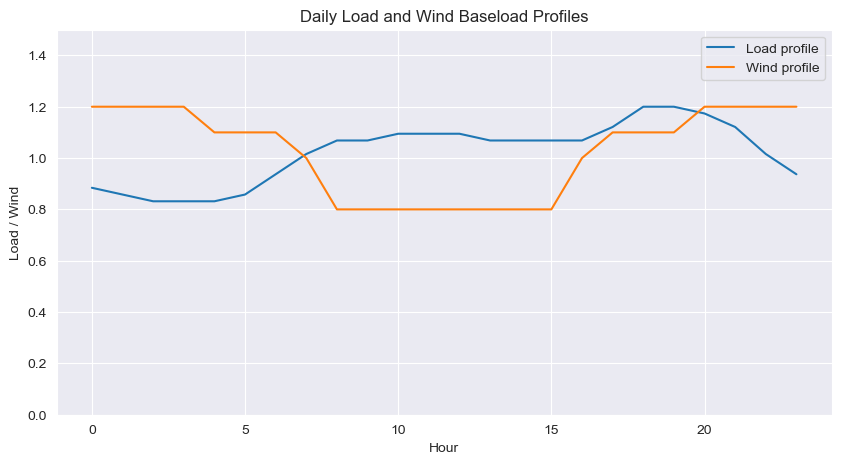

Sample_Nr    500.500000
Hour          11.500000
L1            10.212285
L2            81.698931
L3            71.393796
W1             3.739581
W2            11.248760
dtype: float64


In [67]:

# Define parameters
loads_mean = [10, 80, 70]  # Mean loads for L1, L2, L3
wind_mean = [10, 30]  # Mean wind capacities for W1, W2

# Call the function
samples_data = generate_samples(load_profile, wind_profile, num_samples=1000, loads_mean=loads_mean, wind_mean=wind_mean)

# Define column names
columns = ["Sample_Nr", "Hour", "L1", "L2", "L3", "W1", "W2"]

# Convert to DataFrame
samples_df = pd.DataFrame(samples_data, columns=columns)

# Plot the daily profiles, with y axis going from 0 to 1.5
plt.figure(figsize=(10, 5))
plt.plot(load_profile, label="Load profile")
plt.plot(wind_profile, label="Wind profile")
plt.ylabel("Load / Wind")
plt.ylim(0,1.5)
plt.xlabel("Hour")
plt.legend()
plt.title("Daily Load and Wind Baseload Profiles")
plt.grid(True)
plt.show()

print(samples_df.mean())

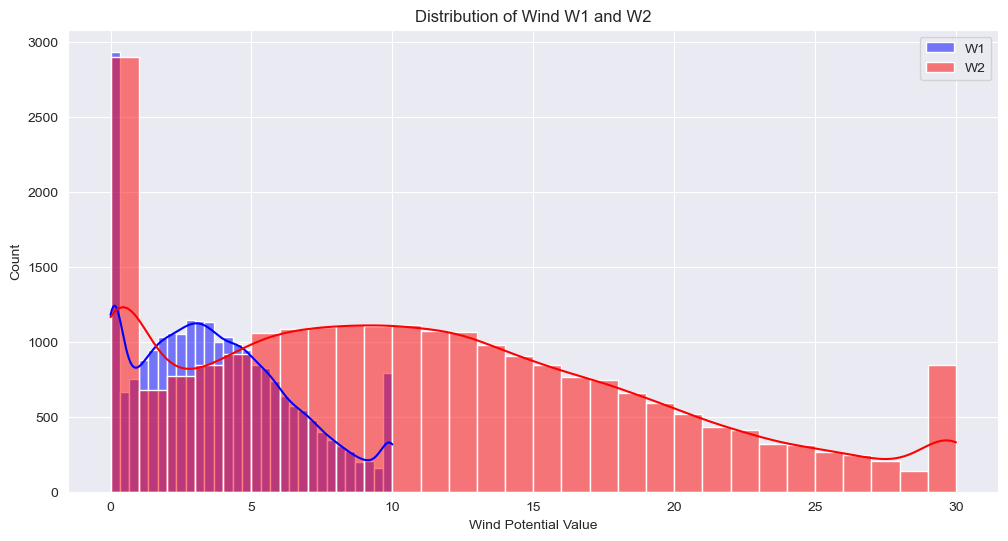

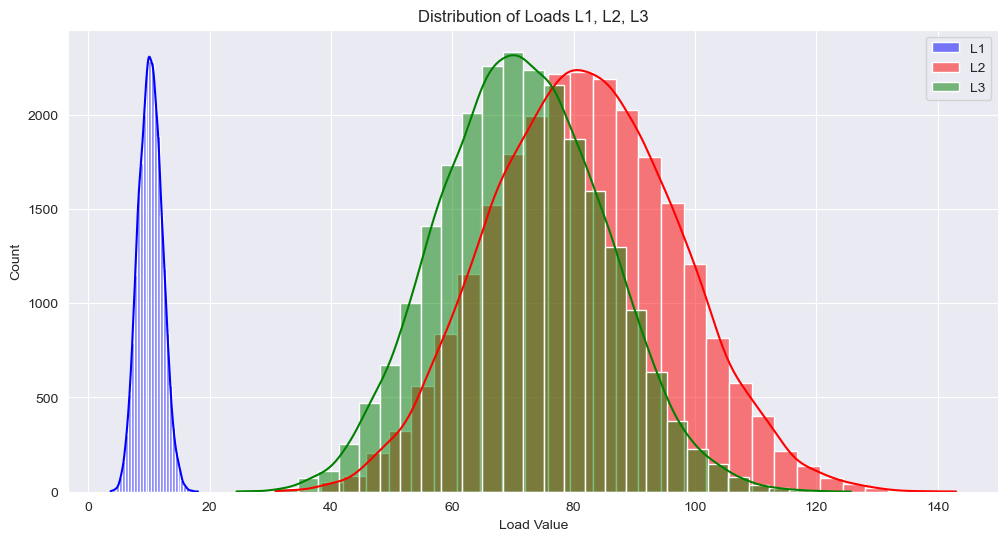

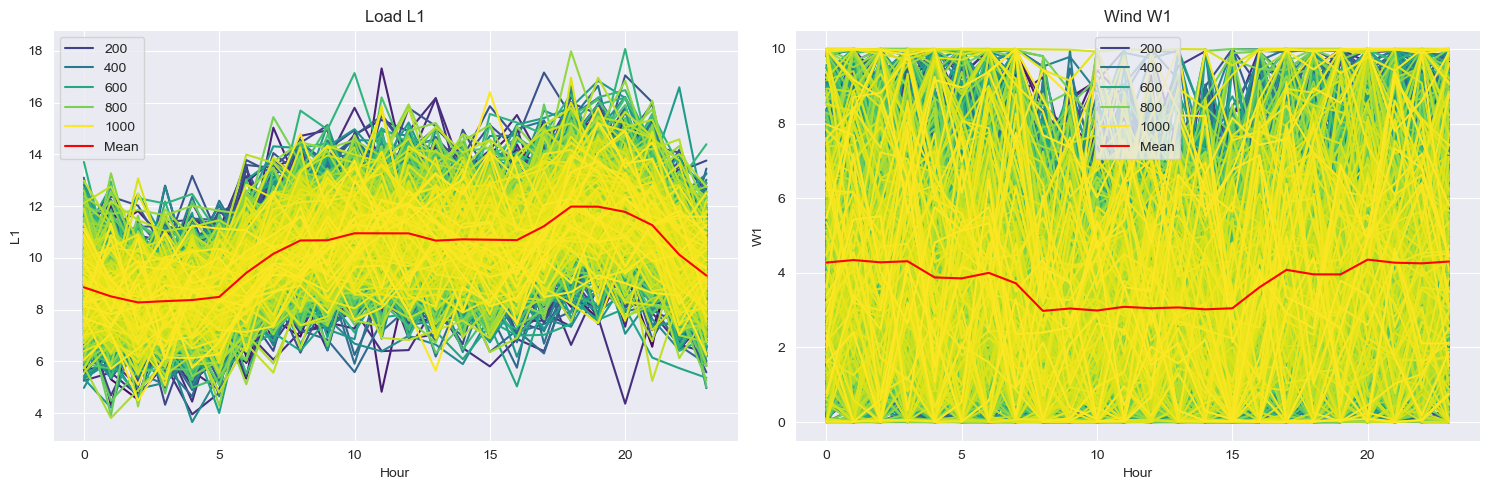

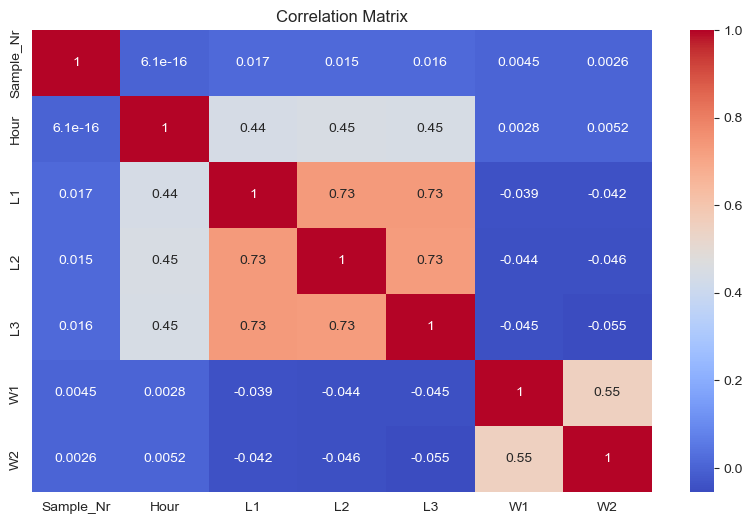

In [68]:
# Plot distribution of Wind Production
plt.figure(figsize=(12, 6))
sns.histplot(data=samples_df, x="W1", kde=True, bins=30, color="blue", label="W1")
sns.histplot(data=samples_df, x="W2", kde=True, bins=30, color="red", label="W2")
plt.title("Distribution of Wind W1 and W2")
plt.xlabel('Wind Potential Value')
plt.legend()
plt.show()

# Plot of distribution of Loads
plt.figure(figsize=(12, 6))
sns.histplot(data=samples_df, x="L1", kde=True, bins=30, color="blue", label="L1")
sns.histplot(data=samples_df, x="L2", kde=True, bins=30, color="red", label="L2")
sns.histplot(data=samples_df, x="L3", kde=True, bins=30, color="green", label="L3")
plt.title("Distribution of Loads L1, L2, L3")
plt.xlabel('Load Value')
plt.legend()
plt.show()

# Plot the samples for load L1 and W1 in two subplots
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(x="Hour", y="L1", data=samples_df, hue="Sample_Nr", palette="viridis")
# Add average load line per hour
sns.lineplot(x="Hour", y="L1", data=samples_df, color="red", label="Mean", ci=None)
plt.title("Load L1")
plt.subplot(1, 2, 2)
sns.lineplot(x="Hour", y="W1", data=samples_df, hue="Sample_Nr", palette="viridis")
# Add average wind line per hour
sns.lineplot(x="Hour", y="W1", data=samples_df, color="red", label="Mean", ci=None)
plt.title("Wind W1")
plt.tight_layout()
plt.show()

# Correlation Matrix
corr = samples_df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Step 02: Optimisation Model

In [22]:
# Load the data from the data folder
wind_forecast = samples_df[['Hour', 'W1', 'W2']].copy()
load = samples_df[['Hour', 'L1', 'L2','L3']].copy()
bus = pd.read_csv('Data/B (power transfer factor of each bus to each line).csv', delimiter=';')
max_prod = pd.read_csv('Data/Maximum production of generating units.csv', delimiter=';')
min_prod = pd.read_csv('Data/Minimum production of generating units.csv', delimiter=';')
min_down_time = pd.read_csv('Data/Minimum down time of generating units.csv', delimiter=';')
min_up_time = pd.read_csv('Data/Minimum up time of generating units.csv', delimiter=';')
prod_cost = pd.read_csv('Data/Production cost of generating units.csv', delimiter=';')
ramp_rate = pd.read_csv('Data/Ramping rate of generating units.csv', delimiter=';')
start_up_cost = pd.read_csv('Data/Start-up cost of generating units.csv', delimiter=';')
transmission_cap = pd.read_csv('Data/Transmission capacity of lines.csv', delimiter=';')


In [23]:
Nodes = ['Node 1', 'Node 2', 'Node 3', 'Node 4', 'Node 5', 'Node 6']
Generator = ['G1', 'G2', 'G3']
Generator_node = {'Node 1': 'G1', 'Node 2': 'G2', 'Node 6': 'G3'}
Load = ['L1', 'L2', 'L3']
Load_node = {'Node 4': 'L1', 'Node 5': 'L2', 'Node 6': 'L3'}
Wind = ['W1', 'W2']
Wind_node = {'Node 4': 'W1', 'Node 5': 'W2'}
Transmission = ['Line 1', 'Line 2', 'Line 3', 'Line 4', 'Line 5', 'Line 6','Line 7']
Transmission_node = {'Line 1': ['Node 1', 'Node 2'], 'Line 2': ['Node 2', 'Node 3'], 'Line 3': ['Node 3', 'Node 6'], 'Line 4': ['Node 5', 'Node 6'], 'Line 5': ['Node 4', 'Node 5'], 'Line 6': ['Node 2', 'Node 4'],'Line 6': ['Node 1', 'Node 4']}    

In [24]:
# Create matrix with the nodes as columns and the generators, loads and winds as rows, with 1 if connected to the node
Gen_n = np.zeros((len(Generator), len(Nodes)))
Load_n = np.zeros((len(Load), len(Nodes)))
Wind_n = np.zeros((len(Wind), len(Nodes)))
Transmission_n = np.zeros((len(Transmission), len(Nodes)))

# Populate the matrix
for i, g in enumerate(Generator):  # Iterate over generators
    for j, node in enumerate(Nodes):  # Iterate over nodes
        if Generator_node.get(node) == g:  # Check if generator is connected to the node
            Gen_n[i, j] = 1

for i, l in enumerate(Load):  # Iterate over loads
    for j, node in enumerate(Nodes):  # Iterate over nodes
        if Load_node.get(node) == l:  # Check if load is connected to the node
            Load_n[i, j] = 1

for i, w in enumerate(Wind):  # Iterate over winds
    for j, node in enumerate(Nodes):  # Iterate over nodes
        if Wind_node.get(node) == w:  # Check if wind is connected to the node
            Wind_n[i, j] = 1

for i, t in enumerate(Transmission):  # Iterate over transmission lines
    connected_nodes = Transmission_node.get(t, [])  # Get nodes connected by the transmission line
    for node in connected_nodes:  # For each node connected by the transmission line
        if node in Nodes:  # Ensure the node is valid (exists in Nodes list)
            j = Nodes.index(node)  # Get the column index for the node in Transmission_n
            Transmission_n[i, j] = 1  # Set the corresponding element to 1
            


In [25]:
# Define the input data class
class InputData:
    
    def __init__(
        self,
        wind_forecast: pd.DataFrame, 
        bus: pd.DataFrame,
        load: pd.DataFrame,
        max_prod: pd.DataFrame,
        min_prod: pd.DataFrame,
        min_down_time: pd.DataFrame,
        min_up_time: pd.DataFrame,
        prod_cost: pd.DataFrame,
        ramp_rate: pd.DataFrame,
        start_up_cost: pd.DataFrame,
        transmission_cap: pd.DataFrame
    ):
        self.time = range(len(wind_forecast))  #maybe define it with lenght of wind_production
        self.wind_forecast = wind_forecast
        self.bus = bus
        self.load = load
        self.max_prod = max_prod
        self.min_prod = min_prod
        self.min_down_time = min_down_time
        self.min_up_time = min_up_time
        self.prod_cost = prod_cost
        self.ramp_rate = ramp_rate
        self.start_up_cost = start_up_cost
        self.transmission_cap = transmission_cap
        self.M = 1000000  # Penalty for having flexible demand
        self.Gen_n = Gen_n  # Matrix mapping generators to nodes
        self.Load_n = Load_n # Matrix mapping loads to nodes
        self.Wind_n = Wind_n # Matrix mapping wind to nodes
        
        


In [26]:
class Expando(object):
    '''
        A small class which can have attributes set
    '''
    pass

In [27]:
# Define the optimization model class

class EconomicDispatch():
        
        def __init__(self, input_data: InputData):
            self.data = input_data 
            self.variables = Expando()
            self.constraints = Expando() 
            self.results = Expando() 
            self._build_model() 
            
        def _build_variables(self):
            # one binary variable for the status of each generator
            self.variables.status = {
                (i, t): self.model.addVar(vtype=GRB.BINARY, 
                                            name='status_G{}_{}'.format(i, t)) 
                                            for i in range(1, len(self.data.max_prod)+1) 
                                            for t in self.data.time}
            
            # one variable for each generator for each time of the day
            self.variables.prod_gen = {
                 (i, t): self.model.addVar(lb=0, ub=self.data.max_prod.iloc[i-1, 0], 
                                           name='generation_G{}_{}'.format(i, t)) 
                                           for i in range(1, len(self.data.max_prod)+1) 
                                           for t in self.data.time}
            
            # one variable for each wind generator for each time of the day
            self.variables.prod_wind = {
                 (i, t): self.model.addVar(lb=0, ub=self.data.wind_forecast.iloc[t, i], 
                                            name='wind_generation_W{}_{}'.format(i, t)) 
                                            for i in range(1, len(self.data.wind_forecast.iloc[0, :])) 
                                            for t in self.data.time}
            
            # one variable for each start-up cost for each generator
            self.variables.start_up_cost = {
                 (i, t): self.model.addVar(lb=0, 
                                            name='start_up_cost_G{}_{}'.format(i, t)) 
                                            for i in range(1, len(self.data.max_prod)+1) 
                                            for t in self.data.time}
            
            # add two slack variables to always make the model feasible, allowing the demand to be flexible
            self.variables.epsilon = {
                 (n, t): self.model.addVar(lb=0, 
                                           name='epsilon_Bus{}_{}'.format(n, t)) 
                                           for n in range(1, len(self.data.bus.iloc[0,:])+1) 
                                           for t in self.data.time}
            self.variables.delta = {
                 (n, t): self.model.addVar(lb=0, 
                                           name='delta_Bus{}_{}'.format(n, t))
                                           for n in range(1, len(self.data.bus.iloc[0,:])+1)
                                           for t in self.data.time}
            
            
        def _build_constraints(self):
            # Minimum capacity of the generator
            self.constraints.min_capacity = {
                (i, t): self.model.addConstr(
                    self.variables.prod_gen[i, t] >= self.data.min_prod.iloc[i-1, 0] * self.variables.status[i, t]
                ) for i in range(1, len(self.data.max_prod)+1) for t in self.data.time}
            # Maximum capacity of the generator
            self.constraints.max_capacity = {
                (i, t): self.model.addConstr(
                    self.variables.prod_gen[i, t] <= self.data.max_prod.iloc[i-1, 0] * self.variables.status[i, t]
                ) for i in range(1, len(self.data.max_prod)+1) for t in self.data.time}

            # Power balance constraint
            self.constraints.power_balance = {
                t: self.model.addConstr(
                    gp.quicksum(self.variables.prod_gen[i, t] for i in range(1, len(self.data.max_prod) + 1)) +
                    gp.quicksum(self.variables.prod_wind[i, t] for i in range(1, len(self.data.wind_forecast.iloc[0, :]))) == 
                    gp.quicksum(self.data.load.iloc[t, i] * Load_n[i-1, n-1] for i in range(1, len(self.data.load.iloc[0, :]))for n in range(1, len(self.data.bus.iloc[0, :]) + 1))
                    + gp.quicksum(self.variables.epsilon[n, t] - self.variables.delta[n, t] for n in range(1, len(self.data.bus.iloc[0, :]) + 1))
                ) for t in self.data.time}
        
            

            # Transmission capacity constraint up
            self.constraints.transmission_capacity_up = {
                    (l, t): self.model.addConstr(
                        gp.quicksum(
                            self.data.bus.iloc[l-1, n-1] * Transmission_n[l-1, n-1] * (
                                self.variables.prod_gen[g, t] * Gen_n[g-1, n-1] +
                                self.variables.prod_wind[w, t] * Wind_n[w-1, n-1] -
                                self.data.load.iloc[t, i] * Load_n[i-1, n-1] -
                                self.variables.epsilon[n, t] +
                                self.variables.delta[n, t]
                            )
                            for n in range(1, len(self.data.bus.iloc[0, :]) + 1)
                            for i in range(1, len(self.data.load.iloc[0, :]))
                            for g in range(1, len(self.data.max_prod) + 1)
                            for w in range(1, len(self.data.wind_forecast.iloc[0, :]))
                        ) <= self.data.transmission_cap.iloc[l-1, 0],
                        name="transmission_capacity_up_L{}_T{}".format(l, t)
                    ) for l in range(1, len(self.data.transmission_cap) + 1)
                    for t in self.data.time
                }


            #Transmission capacity constraint down
            self.constraints.transmission_capacity_down = {
                    (l, t): self.model.addConstr(
                        gp.quicksum(
                            self.data.bus.iloc[l-1, n-1] * Transmission_n[l-1, n-1] * (
                                self.variables.prod_gen[g, t] * Gen_n[g-1, n-1] +
                                self.variables.prod_wind[w, t] * Wind_n[w-1, n-1] -
                                self.data.load.iloc[t, i] * Load_n[i-1, n-1] -
                                self.variables.epsilon[n, t] +
                                self.variables.delta[n, t]
                            )
                            for n in range(1, len(self.data.bus.iloc[0, :]) + 1)
                            for i in range(1, len(self.data.load.iloc[0, :]))
                            for g in range(1, len(self.data.max_prod) + 1)
                            for w in range(1, len(self.data.wind_forecast.iloc[0, :]))
                        ) >= -self.data.transmission_cap.iloc[l-1, 0],
                        name="transmission_capacity_down_L{}_T{}".format(l, t)
                    ) for l in range(1, len(self.data.transmission_cap) + 1)
                    for t in self.data.time
                }

                                     

            #Start-up costs constraint
            self.constraints.start_up_cost = {
                (i, t): self.model.addConstr(
                    self.variables.start_up_cost[i, t] >= self.data.start_up_cost.iloc[i-1, 0] * (self.variables.status[i, t] - self.variables.status[i, t-1])
                ) for i in range(1, len(self.data.max_prod)+1) for t in self.data.time if t > 0}
            self.constraints.start_up_cost_0 = {
                i: self.model.addConstr(
                    self.variables.start_up_cost[i, 0] >= self.data.start_up_cost.iloc[i-1, 0] * self.variables.status[i, 0]
                ) for i in range(1, len(self.data.max_prod)+1)}
            
            # Ramping constraint
            self.constraints.ramping_up = {
                (i, t): self.model.addConstr(
                    self.variables.prod_gen[i, t] - self.variables.prod_gen[i, t-1] <= self.data.ramp_rate.iloc[i-1, 0]
                ) for i in range(1, len(self.data.max_prod)+1) for t in self.data.time if t > 0}
            self.constraints.ramping_down = {
                (i, t): self.model.addConstr(
                    self.variables.prod_gen[i, t-1] - self.variables.prod_gen[i, t] <= self.data.ramp_rate.iloc[i-1, 0]
                ) for i in range(1, len(self.data.max_prod)+1) for t in self.data.time if t > 0}
            
            # Minimum up time constraint
            self.constraints.min_up_time = {
                (i, t, to): self.model.addConstr(
                    -self.variables.status[i, t - 1] + self.variables.status[i, t] - self.variables.status[i, to] <= 0
                ) for i in range(1, len(self.data.max_prod)+1) 
                for t in self.data.time 
                for to in range(t, min(t + self.data.min_up_time.iloc[i-1, 0], len(self.data.time))) if t > 0}
            
            # Minimum down time constraint
            self.constraints.min_down_time = {
                (i, t, to): self.model.addConstr(
                    self.variables.status[i, t - 1] - self.variables.status[i, t] + self.variables.status[i, to] <= 1
                ) for i in range(1, len(self.data.max_prod)+1) 
                for t in self.data.time 
                for to in range(t, min(t + self.data.min_down_time.iloc[i-1, 0], len(self.data.time))) if t > 0}
            


        def _build_objective(self):
            # Objective function
            self.model.setObjective(
                gp.quicksum(self.data.prod_cost.iloc[i-1, 0]*self.variables.prod_gen[i, t] for i in range(1, len(self.data.max_prod)+1) for t in self.data.time) +
                gp.quicksum(self.variables.start_up_cost[i, t] for i in range(1, len(self.data.max_prod)+1) for t in self.data.time) +
                self.data.M * (gp.quicksum(self.variables.epsilon[n, t] + self.variables.delta[n, t] for n in range(1, len(self.data.bus.iloc[0,:])+1) for t in self.data.time))
            )

        def _build_model(self):
            self.model = gp.Model('EconomicDispatch')
            self._build_variables()
            self._build_constraints()
            self._build_objective()
            self.model.update()

        def optimize(self):
            self.model.optimize()
            self._extract_results()

        def _extract_results(self):
            self.results.production = pd.DataFrame({
                
                'hour': [self.data.wind_forecast.iloc[t, 0] for t in self.data.time],
                #'time': [t for t in self.data.time],
                #'status G1': [self.variables.status[1, t].x for t in self.data.time],
                #'status G2': [self.variables.status[2, t].x for t in self.data.time],
                #'status G3': [self.variables.status[3, t].x for t in self.data.time],
                #'start_up_cost 1': [self.variables.start_up_cost[1, t].x for t in self.data.time],
                #'start_up_cost 2': [self.variables.start_up_cost[2, t].x for t in self.data.time],
                #'start_up_cost 3': [self.variables.start_up_cost[3, t].x for t in self.data.time],
                'generation 1': [self.variables.prod_gen[1, t].x for t in self.data.time],
                'generation 2': [self.variables.prod_gen[2, t].x for t in self.data.time],
                'generation 3': [self.variables.prod_gen[3, t].x for t in self.data.time],
                'wind generation 1': [self.variables.prod_wind[1, t].x for t in self.data.time],
                'wind generation 2': [self.variables.prod_wind[2, t].x for t in self.data.time],
                'load 1': [self.data.load.iloc[t, 1] for t in self.data.time],
                'load 2': [self.data.load.iloc[t, 2] for t in self.data.time],
                'load 3': [self.data.load.iloc[t, 3] for t in self.data.time],
                'epsilon 1': [self.variables.epsilon[1, t].x for t in self.data.time],
                'delta 1': [self.variables.delta[1, t].x for t in self.data.time],
                'epsilon 2': [self.variables.epsilon[2, t].x for t in self.data.time],
                'delta 2': [self.variables.delta[2, t].x for t in self.data.time],
                'epsilon 3': [self.variables.epsilon[3, t].x for t in self.data.time],
                'delta 3': [self.variables.delta[3, t].x for t in self.data.time],
                'epsilon 4': [self.variables.epsilon[4, t].x for t in self.data.time],
                'delta 4': [self.variables.delta[4, t].x for t in self.data.time],
                'epsilon 5': [self.variables.epsilon[5, t].x for t in self.data.time],
                'delta 5': [self.variables.delta[5, t].x for t in self.data.time],
                'epsilon 6': [self.variables.epsilon[6, t].x for t in self.data.time],
                'delta 6': [self.variables.delta[6, t].x for t in self.data.time]
            })

            # Add columns for each transmission line's binding status at each time
            for l in range(1, len(self.data.transmission_cap) + 1):
                up_binding = []
                down_binding = []
                
                for t in self.data.time:
                    up_constraint = self.constraints.transmission_capacity_up[l, t]
                    down_constraint = self.constraints.transmission_capacity_down[l, t]

                    # Append binding status (True if binding, based on slack value)
                    up_binding.append(abs(up_constraint.slack) < 1e-6)
                    down_binding.append(abs(down_constraint.slack) < 1e-6)

                # Add the binding status as new columns in the main production DataFrame
                self.results.production[f'transmission_up_binding_L{l}'] = up_binding
                self.results.production[f'transmission_down_binding_L{l}'] = down_binding

            self.results.unit_commitment = pd.DataFrame({
                'hour': [self.data.wind_forecast.iloc[t, 0] for t in self.data.time],
                'G1': [self.variables.status[1, t].x for t in self.data.time],
                'G2': [self.variables.status[2, t].x for t in self.data.time],
                'G3': [self.variables.status[3, t].x for t in self.data.time]
            })
            
        def _print_model(self):
            self.model.write('EconomicDispatch.lp')        
            
                 

In [28]:
# Run the model
input_data = InputData(wind_forecast, bus, load, max_prod, min_prod, min_down_time, min_up_time, prod_cost, ramp_rate, start_up_cost, transmission_cap)
model = EconomicDispatch(input_data)
model.optimize()
results = model.results.production
unit_comitment = model.results.unit_commitment #to be used for the next steps
# model._build_model()
# model._print_model()


Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-11



KeyboardInterrupt



In [ ]:
# Save results to csv
results.to_csv('Data/results1000.csv', index=False)
unit_comitment.to_csv('Data/unit_comitment1000.csv', index=False)

# Step 03: Binary Classification

### Data Preprocessing

Original feature space:

In [3]:
# Load data
results = pd.read_csv('Data/results1000.csv', delimiter=',') 
results_UC = pd.read_csv('Data/unit_comitment1000.csv', delimiter=',')

# Check if units are always ON or OFF
targets = results_UC[["G1","G2","G3"]]
print(targets.mean())

# Filter out units that are always ON or OFF
units_to_classify = targets.columns[(targets.mean() > 0) & (targets.mean() < 1)]
print(f"Units to classify: {units_to_classify}")
print("-"*50)
targets = targets[units_to_classify]
features = results[['wind generation 1', 'wind generation 2', 'load 1', 'load 2', 'load 3']]

# Standardize features
scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(features), columns=results[['wind generation 1', 'wind generation 2', 'load 1', 'load 2', 'load 3']].columns)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(features, targets, test_size=0.3, random_state=42, shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# Shape
print("Shapes: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_val.shape, y_val.shape)

G1    1.000000
G2    0.696333
G3    0.965833
dtype: float64
Units to classify: Index(['G2', 'G3'], dtype='object')
--------------------------------------------------
Shapes:  (16800, 5) (3600, 5) (16800, 2) (3600, 2) (3600, 5) (3600, 2)


Large feature space (incl. lagged features):

In [4]:
# Lagging Function
def lag_features(features, lags, targets=None, lag_targets=False):
    """
    Creates lagged versions of the features for a given number of lags.
    Optionally adds lagged versions of the targets as well.
    Parameters:
    - features (pd.DataFrame): The input feature DataFrame.
    - lags (int): Number of lagged steps to create.
    - targets (pd.DataFrame, optional): The target DataFrame to lag.
    - lag_targets (bool): Whether to include lagged versions of targets.
    """
    lagged_features = features.copy()
    for lag in range(1, lags + 1):
        lagged = features.shift(lag)
        lagged.columns = [f"{col}_lag{lag}" for col in features.columns]
        lagged_features = pd.concat([lagged_features, lagged], axis=1)

    # Add lagged targets if specified
    if lag_targets and targets is not None:
        for lag in range(1, lags + 1):
            lagged = targets.shift(lag)
            lagged.columns = [f"{col}_lag{lag}" for col in targets.columns]
            lagged_features = pd.concat([lagged_features, lagged], axis=1)
    
    # Drop rows with NaN values from lagging
    return lagged_features.dropna()

In [5]:
# Multi-Class Target Transformation (nested)
def transform_targets_to_multiclass(targets_df):
    """
    Transforms binary targets (G2, G3) into multi-class categories.
    """
    def map_targets(row):
        if row['G2'] == 1 and row['G3'] == 1:
            return 'A'
        elif row['G2'] == 0 and row['G3'] == 1:
            return 'B'
        elif row['G2'] == 1 and row['G3'] == 0:
            return 'C'
        elif row['G2'] == 0 and row['G3'] == 0:
            return 'D'
        else:
            raise ValueError("Unexpected row values: G2={}, G3={}".format(row['G2'], row['G3'])) # Catch unexpected values

    # Copy targets
    targets_MC = targets_df.copy()    
    # Apply transformation
    targets_MC['category'] = targets_df.apply(map_targets, axis=1)
    # Drop original columns
    targets_MC = targets_MC.drop(columns=['G2', 'G3'])
    # Convert to categorical codes (0, 1, 2, 3)
    targets_MC['category'] = pd.Categorical(targets_MC['category']).codes
    return targets_MC[['category']]  # Return only the transformed category

In [6]:
# Reverse Mapping
def reverse_map_categories(categories, add_g1=True):
    """
    Reverse map from multi-class categories to binary G1, G2, G3, ensuring column order.
    """
    reverse_mapping = {
        0: (1, 1),  # A
        1: (0, 1),  # B
        2: (1, 0),  # C
        3: (0, 0),  # D
    }

    if isinstance(categories, (pd.Series, pd.DataFrame)):
        mapped = categories.map(reverse_mapping)
        result = pd.DataFrame(mapped.tolist(), columns=['G2', 'G3'])
        if add_g1:
            result.insert(0, 'G1', 1)  # Ensure G1 is the first column
        return result[['G1', 'G2', 'G3']] if add_g1 else result[['G2', 'G3']]

    result = reverse_mapping.get(categories, (None, None))
    return (1, *result) if add_g1 else result

In [7]:
# Combine Lagging and Multi-Class Targets
def prepare_data(features, targets, lags, lag_targets=False):
    """
    Combines feature lagging and multi-class target transformation.
    """
    # Lag the features
    lagged_features = lag_features(features, lags, targets, lag_targets=lag_targets)

    # Add hours to lagged features
    lagged_features['Hour'] = features.index[lags:]

    # Cyclic Scaling of Hour
    lagged_features['Hour_sin'] = np.sin(2 * np.pi * lagged_features['Hour'] / 24)
    lagged_features['Hour_cos'] = np.cos(2 * np.pi * lagged_features['Hour'] / 24)
    lagged_features = lagged_features.drop(columns=['Hour'])
    
    # Align targets with lagged features
    lagged_targets = targets.iloc[lags:].reset_index(drop=True)  # Drop first rows to match lagged features

    # Transform targets to multi-class
    multiclass_targets = transform_targets_to_multiclass(lagged_targets) #.reset_index(drop=True)

    # Ensure alignment
    assert lagged_features.shape[0] == multiclass_targets.shape[0], "Mismatch in rows between features and targets"
    
    return lagged_features, multiclass_targets #.reset_index(drop=True)


In [8]:
# Add a function to evaluate and display performance metrics
def evaluate_performance(y_true, y_pred, classes=['A', 'B', 'C', 'D'], title="Model"):
    """
    Evaluates the performance of a classification model using multiple metrics
    and visualizes the confusion matrix.
    """
    # Compute metrics
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    mcc = matthews_corrcoef(y_true, y_pred)
    bal_accuracy = balanced_accuracy_score(y_true, y_pred)

    # Print metrics
    print(f"Performance Metrics for {title}:")
    print(f"F1 Score (Weighted): {f1_weighted:.3f}")
    print(f"F1 Score (Macro): {f1_macro:.3f}")
    print(f"MCC: {mcc:.3f}")
    print(f"Balanced Accuracy: {bal_accuracy:.3f}") # kick?
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes,zero_division=0))
    print("-"*50)

In [9]:
# Data Preparation for Multi-Class Classification
lagged_features, multiclass_targets = prepare_data(features, targets, lags=3)
# Train-Test Split
X_train_MC, X_temp_MC, y_train_MC, y_temp_MC = train_test_split(lagged_features, multiclass_targets['category'], test_size=0.3, random_state=42, shuffle=False)
X_test_MC, X_val_MC, y_test_MC, y_val_MC = train_test_split(X_temp_MC, y_temp_MC, test_size=0.5, random_state=42, shuffle=False)

# Reduce X_test_MC to original columns
X_test_MC_reduced = X_test_MC[['wind generation 1', 'wind generation 2', 'load 1', 'load 2', 'load 3', 'Hour_sin', 'Hour_cos']].copy()
# Reverse hour cyclic scaling
X_test_MC_reduced['Hour'] = (np.arctan2(X_test_MC_reduced['Hour_sin'], X_test_MC_reduced['Hour_cos']) / (2 * np.pi) * 24).round().astype(int) % 24
X_test_MC_reduced = X_test_MC_reduced.drop(columns=['Hour_sin', 'Hour_cos'])
# Rescale features -> Select only the features to rescale 
features_to_rescale = ['wind generation 1', 'wind generation 2', 'load 1', 'load 2', 'load 3']
non_scaled_features = ['Hour']
hour_column = X_test_MC_reduced[non_scaled_features].copy()
scaled_features = pd.DataFrame(
    scaler.inverse_transform(X_test_MC_reduced[features_to_rescale]),
    columns=features_to_rescale,
    index=X_test_MC_reduced.index
)
X_test_MC_reduced = pd.concat([hour_column, scaled_features], axis=1)
# Rename & reorder columns
X_test_MC_reduced.columns = ['Hour', 'W1', 'W2', 'L1', 'L2', 'L3']
X_test_MC_reduced = X_test_MC_reduced[['Hour', 'L1', 'L2', 'L3', 'W1', 'W2']]

# Save to csv
X_test_MC_reduced.to_csv('Data/X_test_MC.csv', index=False)
print("\nTest Data:")
print(X_test_MC_reduced.head())


Test Data:
       Hour     L1     L2     L3        W1         W2
16800     0  10.41  59.00  76.38  0.000000  15.036853
16801     1   8.33  54.34  49.13  0.000000   1.800000
16802     2   8.20  51.96  51.60  0.000000   1.760000
16803     3   6.38  47.28  52.23  3.688951   0.000000
16804     4   7.37  38.13  51.71  0.000000   0.000000


Simple Models:

In [10]:
# Train Logistic Regression
logreg_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
logreg_model.fit(X_train_MC, y_train_MC)
y_pred_logreg = logreg_model.predict(X_test_MC)
# Evaluate
evaluate_performance(y_test_MC, y_pred_logreg, title="Logistic Regression")

# Train SVM with RBF kernel
svm_rbf_model = SVC(kernel='rbf', random_state=42, class_weight='balanced', probability=True, C=10, gamma='scale')
svm_rbf_model.fit(X_train_MC, y_train_MC)
y_pred_svm_rbf = svm_rbf_model.predict(X_test_MC)
# Evaluate
evaluate_performance(y_test_MC, y_pred_svm_rbf, title="SVM with RBF Kernel")

# Reverse map
y_pred_logreg = reverse_map_categories(pd.Series(y_pred_logreg))
y_pred_reversed_svm_rbf = reverse_map_categories(pd.Series(y_pred_svm_rbf))
y_test_reversed = reverse_map_categories(y_test_MC)

# # Save Results to CSV
#y_pred_reversed_svm_rbf.to_csv('Data/y_pred_svm.csv', index=False)
#y_pred_logreg.to_csv('Data/y_pred_logreg.csv', index=False)
#y_test_reversed.to_csv('Data/y_test.csv', index=False)

# Print Results
print("Predicted Values (Logistic Regression):")
print(y_pred_logreg.head())
print("Predicted Values (SVM with RBF kernel):")
print(y_pred_reversed_svm_rbf.head())
print("\nTrue Values:")
print(y_test_reversed.head())

Performance Metrics for Logistic Regression:
F1 Score (Weighted): 0.888
F1 Score (Macro): 0.678
MCC: 0.756
Balanced Accuracy: 0.849

Classification Report:
              precision    recall  f1-score   support

           A       0.96      0.89      0.92      2472
           B       0.77      0.86      0.81      1008
           C       0.06      0.67      0.11         3
           D       0.78      0.98      0.87       117

    accuracy                           0.88      3600
   macro avg       0.64      0.85      0.68      3600
weighted avg       0.90      0.88      0.89      3600

--------------------------------------------------
Performance Metrics for SVM with RBF Kernel:
F1 Score (Weighted): 0.921
F1 Score (Macro): 0.685
MCC: 0.825
Balanced Accuracy: 0.688

Classification Report:
              precision    recall  f1-score   support

           A       0.96      0.93      0.95      2472
           B       0.84      0.89      0.86      1008
           C       0.00      0.00      

Model Selection with GridSearch (Hyperparameter Tuning):

In [11]:
# Logistic Regression Hyperparameter Tuning
def tune_log_reg(X_train, y_train):
    param_grid = {
        'C': [0.01, 0.1, 1, 10],  # Regularization strength
        'solver': ['lbfgs', 'newton-cg', 'saga'],  # Optimization algorithm
    }

    grid_search = GridSearchCV(
        LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial', penalty='l2'),
        param_grid,
        scoring='f1_weighted',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for Logistic Regression: {grid_search.best_params_}")
    print(f"Best cross-validated MCC: {grid_search.best_score_:.3f}")
    return grid_search.best_estimator_


# SVM Hyperparameter Tuning
def tune_svm(X_train, y_train):
    param_grid = {
        'C': [0.1, 1, 10],  # Regularization strength
        'kernel': ['linear', 'poly', 'rbf'],  # Kernels to evaluate
        'degree': [2, 3],  # Degree of polynomial kernel (ignored for others)
        'gamma': ['scale', 'auto'],  # Kernel coefficient
    }
    
    grid_search = GridSearchCV(
        SVC(random_state=42),
        param_grid,
        scoring='f1_weighted',
        cv=5,  # 5-fold cross-validation
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for SVM: {grid_search.best_params_}")
    print(f"Best cross-validated MCC: {grid_search.best_score_:.3f}")
    return grid_search.best_estimator_

# Fine-tune Logistic Regression
best_logistic_model = tune_log_reg(X_train_MC, y_train_MC)

# Evaluate Logistic Regression with Best Parameters
y_pred_logreg_tune = best_logistic_model.predict(X_test_MC)
evaluate_performance(y_test_MC, y_pred_logreg_tune, title="Tuned Logistic Regression")

# Fine-tune SVM
best_svm_model = tune_svm(X_train_MC, y_train_MC)

# Evaluate SVM with Best Parameters
y_pred_svm_tune = best_svm_model.predict(X_test_MC)
evaluate_performance(y_test_MC, y_pred_svm_tune, title="Tuned SVM")

# Reverse map
y_pred_logreg_tune = reverse_map_categories(pd.Series(y_pred_logreg_tune))
y_pred_svm_tune = reverse_map_categories(pd.Series(y_pred_svm_tune))



Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\konst\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters for Logistic Regression: {'C': 1, 'solver': 'newton-cg'}
Best cross-validated MCC: 0.912
Performance Metrics for Tuned Logistic Regression:
F1 Score (Weighted): 0.911
F1 Score (Macro): 0.685
MCC: 0.801
Balanced Accuracy: 0.679

Classification Report:
              precision    recall  f1-score   support

           A       0.93      0.95      0.94      2472
           B       0.86      0.82      0.84      1008
           C       0.00      0.00      0.00         3
           D       0.97      0.95      0.96       117

    accuracy                           0.91      3600
   macro avg       0.69      0.68      0.68      3600
weighted avg       0.91      0.91      0.91      3600

--------------------------------------------------
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for SVM: {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validated MCC: 0.930
Performance Metrics for Tuned SVM:
F1 Score (Weighted): 0.930
F1 Score 

In [12]:
num_rows = len(y_pred_logreg_tune)
hours = list(range(24)) * (num_rows // 24) + list(range(num_rows % 24))  # Create repeating hours (0-23)
# Add the 'Hour' column to y_pred_logreg_tune, y_pred_svm_tune, and y_test_reversed
y_pred_logreg_tune['Hour'] = hours[:num_rows]
y_pred_svm_tune['Hour'] = hours[:num_rows]
y_test_reversed['Hour'] = hours[:num_rows]


# Ensure 'Hour' is the first column
y_pred_logreg_tune = y_pred_logreg_tune[['Hour', 'G1', 'G2', 'G3']]
y_pred_svm_tune = y_pred_svm_tune[['Hour', 'G1', 'G2', 'G3']]
y_test_reversed = y_test_reversed[['Hour', 'G1', 'G2', 'G3']]

# Save Results to CSV
y_pred_logreg_tune.to_csv('Data/y_pred_logreg_tune.csv', index=False)
y_pred_svm_tune.to_csv('Data/y_pred_svm_tune.csv', index=False)
y_test_reversed.to_csv('Data/y_test.csv', index=False)

# Print results
print("Predicted Values (Tuned Logistic Regression):")
print(y_pred_logreg_tune.head())
print("Predicted Values (Tuned SVM):")
print(y_pred_svm_tune.head())
print("\nTrue Values:")
print(y_test_reversed.tail())

Predicted Values (Tuned Logistic Regression):
   Hour  G1  G2  G3
0     0   1   0   1
1     1   1   0   1
2     2   1   0   1
3     3   1   0   0
4     4   1   0   0
Predicted Values (Tuned SVM):
   Hour  G1  G2  G3
0     0   1   0   1
1     1   1   0   1
2     2   1   0   1
3     3   1   0   0
4     4   1   0   0

True Values:
      Hour  G1  G2  G3
3595    19   1   1   1
3596    20   1   1   1
3597    21   1   1   1
3598    22   1   1   1
3599    23   1   1   1


In [13]:
# Define function for binary classification loop
def binary_classification_loop(features_lagged, targets, units_to_classify):
    results = {}
    for unit in units_to_classify:
        print(f"--- Processing Unit: {unit} ---")

        # Use the specific unit as the target
        target = targets[[unit]]

        # Train-Test-Validation Split
        X_train_L, X_temp_L, y_train_L, y_temp_L = train_test_split(
            features_lagged, target, test_size=0.3, random_state=42, shuffle=False
        )
        X_test_L, X_val_L, y_test_L, y_val_L = train_test_split(
            X_temp_L, y_temp_L, test_size=0.5, random_state=42, shuffle=False
        )

        # Train and Evaluate Logistic Regression
        best_logistic_model = tune_log_reg(X_train_L, y_train_L.values.ravel())
        y_pred_logreg = best_logistic_model.predict(X_test_L)
        print(f"--- Logistic Regression Performance for {unit} ---")
        evaluate_performance(y_test_L, y_pred_logreg, classes=None, title=f"Tuned Logistic Regression - {unit}")

        # Train and Evaluate SVM
        best_svm_model = tune_svm(X_train_L, y_train_L.values.ravel())
        y_pred_svm = best_svm_model.predict(X_test_L)
        print(f"--- SVM Performance for {unit} ---")
        evaluate_performance(y_test_L, y_pred_svm, classes=None, title=f"Tuned SVM - {unit}")

        # Save Results
        results[unit] = {
            'logistic': {
                'predictions': y_pred_logreg,
                'best_model': best_logistic_model,
            },
            'svm': {
                'predictions': y_pred_svm,
                'best_model': best_svm_model,
            }
        }
        print(f"Finished processing unit: {unit}\n")

    return results

# Adjust targets
lagged_targets = targets.iloc[3:].reset_index(drop=True)  

# Call the function
binary_results = binary_classification_loop(lagged_features, lagged_targets, units_to_classify)



--- Processing Unit: G2 ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\konst\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters for Logistic Regression: {'C': 0.01, 'solver': 'lbfgs'}
Best cross-validated MCC: 0.915
--- Logistic Regression Performance for G2 ---
Performance Metrics for Tuned Logistic Regression - G2:
F1 Score (Weighted): 0.914
F1 Score (Macro): 0.899
MCC: 0.798
Balanced Accuracy: 0.893

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86      1125
         1.0       0.93      0.95      0.94      2475

    accuracy                           0.91      3600
   macro avg       0.91      0.89      0.90      3600
weighted avg       0.91      0.91      0.91      3600

--------------------------------------------------
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for SVM: {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validated MCC: 0.936
--- SVM Performance for G2 ---
Performance Metrics for Tuned SVM - G2:
F1 Score (Weighted): 0.932
F1 Score (Macro): 0.921
MCC: 0

C:\Users\konst\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters for Logistic Regression: {'C': 1, 'solver': 'newton-cg'}
Best cross-validated MCC: 0.995
--- Logistic Regression Performance for G3 ---
Performance Metrics for Tuned Logistic Regression - G3:
F1 Score (Weighted): 0.996
F1 Score (Macro): 0.972
MCC: 0.944
Balanced Accuracy: 0.970

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       120
         1.0       1.00      1.00      1.00      3480

    accuracy                           1.00      3600
   macro avg       0.97      0.97      0.97      3600
weighted avg       1.00      1.00      1.00      3600

--------------------------------------------------
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for SVM: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validated MCC: 0.996
--- SVM Performance for G3 ---
Performance Metrics for Tuned SVM - G3:
F1 Score (Weighted): 0.997
F1 Score (Macro): 0.976
MC

In [14]:
#Initialize predictions with G1 column (filled with 1s for all rows based on the length of predictions)
num_rows = len(next(iter(binary_results.values()))['logistic']['predictions'])  # Get the number of rows from any prediction
logistic_predictions = pd.DataFrame({'G1': [1] * num_rows})  # G1 is always 1
svm_predictions = pd.DataFrame({'G1': [1] * num_rows})  # G1 is always 1
# Add the 'Hour' column to the logistic and SVM predictions

# Add G2 and G3 predictions
logistic_predictions['G2'] = binary_results['G2']['logistic']['predictions']
logistic_predictions['G3'] = binary_results['G3']['logistic']['predictions']

svm_predictions['G2'] = binary_results['G2']['svm']['predictions']
svm_predictions['G3'] = binary_results['G3']['svm']['predictions']

# Add the 'Hour' column to the logistic and SVM predictions
logistic_predictions['Hour'] = hours[:num_rows]
svm_predictions['Hour'] = hours[:num_rows]

# Reorder columns to place 'Hour' first
logistic_predictions = logistic_predictions[['Hour', 'G1', 'G2', 'G3']]
svm_predictions = svm_predictions[['Hour', 'G1', 'G2', 'G3']]

# Save consolidated predictions to CSV
logistic_predictions.to_csv('Data/logistic_predictions.csv', index=False)
svm_predictions.to_csv('Data/svm_predictions.csv', index=False)
# Optional: Save results for each unit
#for unit, result in binary_results.items():
   # pd.DataFrame(result['logistic']['predictions'], columns=[f"{unit}_logistic"]).to_csv(f'Data/{unit}_logistic_predictions.csv', index=False)
    #pd.DataFrame(result['svm']['predictions'], columns=[f"{unit}_svm"]).to_csv(f'Data/{unit}_svm_predictions.csv', index=False)